<a href="https://colab.research.google.com/github/maderix/pytorch-notebooks/blob/main/03_pytorch_cifar10_resnets_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the CIFAR10 task with ResNets

In last experiment, we saw with a basic 4 layer CNN, we could achieve a decent 75% overall accuracy. 

We can always improve upon that by using conventinal CNN architectures by using data regularization and further fine-tuning of hyperparameters and using even deeper networks.

However, in this experiment we'll use a residual architecture to improve upon the accuracy. ResNets and their variants are the defacto standard for CNN architectures


In [2]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

# Residual block

A residual block is a simple conv block which adds the input to its output and returns the result.

So y = F(x) + x


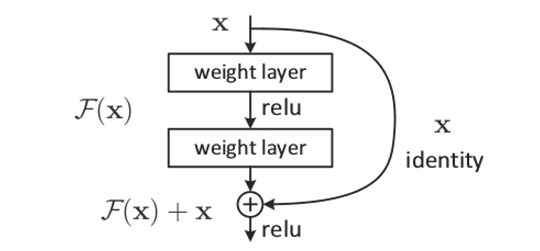

Now, there can be some scenarios where the output from the layer and the identity input have different dimensions. For example, if we consider a CNN where we know that after convolution operation, the size of the input is reduced(dimensionally), then adding input to it is a problem. So, what here can be done is that in the skip connection, we add some operation or function (in this example convolution operation) such that the input is changed or configured to the required dimensions.

So, the definition can be updated here as follows:

`Y = F(x,{Wi}) + Ws*x`

Here, Wi are the parameters given to the CNN layer and Ws term can be implemented with certain convolution configuration to make dimensions of input and output identical.

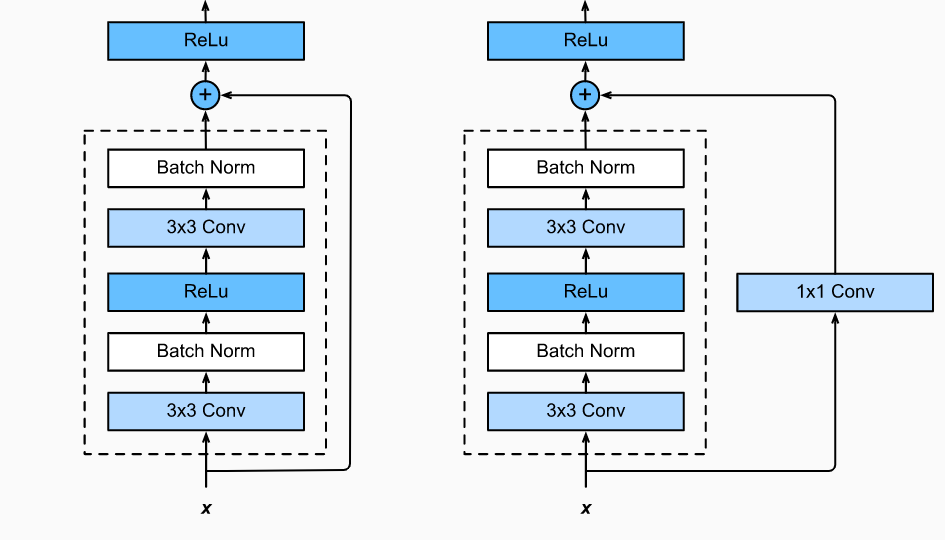

# Resnet18 model

A ResNet18 model is defined as follows as a mixture of residual blocks combined with maxpooling operations.

There are fully connected and sigmoid layers at the end. Since we have only 10 classes in CIFAR10, we will modify the number of classes at the end instead of default 1000 classes present in ImageNet dataset.

Note: We are not aiming for compatibility with stock ResNet18 models so layer names may not match.

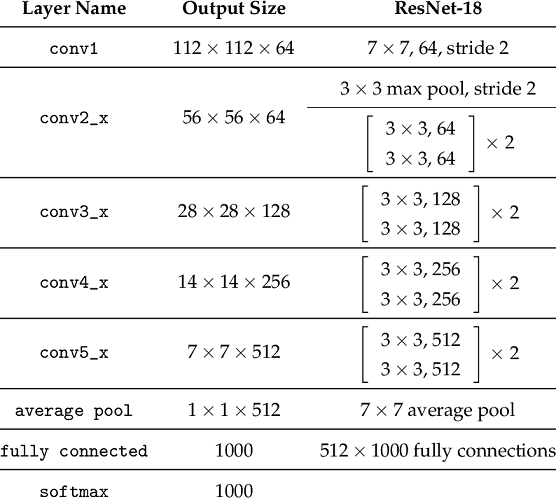

In [13]:
class ResNet18(nn.Module):
  def __init__(self):
    super(ResNet18,self).__init__()
    #compose the full network : Need to figure out a better way to do this
    self.conv_layers = nn.ModuleDict([
              # block_name , in_features, out_features, kernel_size, stride, padding
              ('conv_block1', self.conv_block(3, 64, 3, 1, 1, 'conv_block1')),
              ('max_pool1', nn.MaxPool2d(1, 2)),
              ('res_block1', self.res_block(64, 64, 3, 1, 1, 'res_block1')),
              ('res_block2', self.res_block(64, 64, 3, 1, 1, 'res_block2')),
              ('skip_conv1', self.conv_block(64, 128, 1, 2, 0, 'skip_conv1')),
              ('res_block3', self.res_block(64, 128, 3, 2, 1, 'res_block3')),
              ('res_block4', self.res_block(128, 128, 3, 1, 1, 'res_block4')),
              ('skip_conv2', self.conv_block(128, 256, 1, 2, 0, 'skip_conv2')),
              ('res_block5', self.res_block(128, 256, 3, 2, 1, 'res_block5')),
              ('res_block6', self.res_block(256, 256, 3, 1, 1, 'res_block6')),
              ('skip_conv3', self.conv_block(256, 512, 1, 2, 0, 'skip_conv3')),
              ('res_block7', self.res_block(256, 512, 3, 2, 1, 'res_block7')),
              ('res_block8', self.res_block(512, 512, 3, 1, 1, 'res_block8')),
    ])
    self.fc1 = nn.Linear(512,512)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(512,10)

  # we define a conv_block as a conv+batchnorm for easy composition
  def conv_block(self, in_features, out_features, size, stride=1, padding=0, name=''):
    return nn.Sequential(OrderedDict([
                         (name + '_conv' , nn.Conv2d(in_features, out_features, size, stride=stride, padding=padding)),
                         (name + '_bn' , nn.BatchNorm2d(out_features, 1)),
    ]))
  # a resblock is a combination of two conv blocks of 3x3
  def res_block(self, in_features, out_features, size, stride=1, padding=0, name=''):
    return nn.Sequential(
        self.conv_block(in_features, out_features, size, stride, padding, name),
        nn.ReLU(),
        self.conv_block(out_features, out_features, size, 1, padding, name),
    )
  # forward : lets create the graph
  def forward(self, x):
    x = self.conv_layers['conv_block1'](x)
    m = self.conv_layers['max_pool1'](x)
    x = self.conv_layers['res_block1'](m)
    x = x + m

    s = F.relu(x)
    x = self.conv_layers['res_block2'](s)
    x = x + s
    #second group
    x = F.relu(s)
    s = self.conv_layers['skip_conv1'](x)
    x = self.conv_layers['res_block3'](x)
    x = x + s
    s = F.relu(x)
    x = self.conv_layers['res_block4'](s)
    x = x + s
    #third group
    x = F.relu(x)
    s = self.conv_layers['skip_conv2'](x)
    x = self.conv_layers['res_block5'](x)
    x = x + s

    s = F.relu(x)
    x = self.conv_layers['res_block6'](s)
    x = x + s
    #fourth group
    x = F.relu(x)
    s = self.conv_layers['skip_conv3'](x)
    x = self.conv_layers['res_block7'](x)
    x = x + s

    s = F.relu(x)
    x = self.conv_layers['res_block8'](s)
    x = x + s
    #Linear
    x = F.relu(x)
    #GlobalMaxPooling
    x = F.max_pool2d(x, kernel_size=x.size()[2:], stride=2)
    x = torch.flatten(x, start_dim=1)
    #print(x.shape)
    #Linear
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout1(x)
    x = self.fc2(x)
    x = F.log_softmax(x)
    return x

resnet18 = ResNet18()
print(resnet18)

ResNet18(
  (conv_layers): ModuleDict(
    (conv_block1): Sequential(
      (conv_block1_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_block1_bn): BatchNorm2d(64, eps=1, momentum=0.1, affine=True, track_running_stats=True)
    )
    (max_pool1): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
    (res_block1): Sequential(
      (0): Sequential(
        (res_block1_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (res_block1_bn): BatchNorm2d(64, eps=1, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ReLU()
      (2): Sequential(
        (res_block1_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (res_block1_bn): BatchNorm2d(64, eps=1, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): Sequential(
      (0): Sequential(
        (res_block2_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

# Random **test**
Let's do a random test to test the forward function of our net


In [14]:
random_data = torch.randn((2, 3, 32, 32))
result = resnet18(random_data)
print(result)

tensor([[-2.3271, -2.2613, -2.3041, -2.2830, -2.3333, -2.3224, -2.2807, -2.2832,
         -2.3364, -2.2974],
        [-2.3055, -2.2611, -2.3286, -2.2994, -2.3173, -2.3244, -2.2689, -2.2656,
         -2.3474, -2.3114]], grad_fn=<LogSoftmaxBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [15]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Transform


In [33]:
transform = transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                 #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                ])

In [34]:
cifar10_trainset = datasets.CIFAR10(root='./data',train=True,download=True, transform=transform)
cifar10_testset = datasets.CIFAR10(root='./data',train=False,download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_testset, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.64 -2.117904 tensor([7, 5, 4, 5, 8, 1, 6, 6, 5, 4, 6, 7, 5, 6, 5, 7, 2, 0, 3, 3, 0, 3, 6, 2,
        3, 5, 1, 8, 5, 6, 5, 7, 1, 3, 8, 1, 0, 0, 7, 5, 7, 9, 7, 2, 0, 3, 7, 7,
        9, 0, 1, 0, 9, 2, 9, 0, 5, 7, 0, 5, 4, 3, 1, 8])


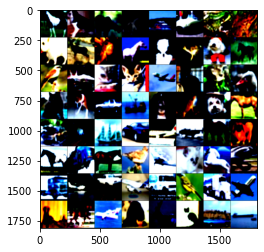

In [36]:
import numpy as np
import matplotlib.pyplot as plt
images,labels = next(iter(train_loader))
print(np.max(images.numpy()),np.min(images.numpy()),labels)
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))

# Training pipeline
Let's define our CIFAR training pipeline, which is quite similar to the MNIST one. Therein lies the power of neural nets, a model can fit multiple datasets. Accuracy may vary according to the complexity of the dataset but tuning may help correct this.

1.   Get model output with current input
2.   Calculate loss
3.   Calculate gradients
4.   Update weights through optimizer

the 'to(device)' function will allow us to place the tensor on GPU if available.

In [37]:
import tqdm

net = ResNet18()
print(sum(p.numel() for p in net.parameters() if p.requires_grad))
learning_rate = 1e-4
epochs = 10
#we use Adam optimizer as it converges faster compared to SGD
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

11441418


In [39]:
net = net.to(device)
#zero out the gradients
for epoch in range(epochs):
  net.train()
  t = tqdm.tqdm(train_loader,leave=True, position=0)
  for images,labels in t:
    images = images.to(device)
    labels = labels.long().to(device)
    optimizer.zero_grad()
    output = net.forward(images)
    train_loss = criterion(output,labels)
    train_loss.backward()
    optimizer.step()
    t.set_description(f'epoch:{epoch+1} : train loss:{train_loss.item():.4f}')
    t.refresh()
  #evaluate after each epoch
  net.eval()
  valid_loss = 0
  for images,labels in test_loader:
  #images,labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      output = net(images)
      valid_loss += criterion(output,labels)
  print(f'epoch:{epoch+1} : valid loss:{valid_loss.item()/len(test_loader):.4f}\n')

  0%|          | 0/782 [00:00<?, ?it/s]

epoch:1 : valid loss:1.3325



  0%|          | 0/782 [00:00<?, ?it/s]

epoch:2 : valid loss:0.9165



  0%|          | 0/782 [00:00<?, ?it/s]

epoch:3 : valid loss:0.7380



  0%|          | 0/782 [00:00<?, ?it/s]

epoch:4 : valid loss:0.6292



  0%|          | 0/782 [00:00<?, ?it/s]

epoch:5 : valid loss:0.5495



  0%|          | 0/782 [00:00<?, ?it/s]

epoch:6 : valid loss:0.5345



  0%|          | 0/782 [00:00<?, ?it/s]

epoch:7 : valid loss:0.5207



  0%|          | 0/782 [00:00<?, ?it/s]

epoch:8 : valid loss:0.4473



  0%|          | 0/782 [00:00<?, ?it/s]

epoch:9 : valid loss:0.4653



epoch:10 : train loss:0.0684: 100%|██████████| 782/782 [06:01<00:00,  2.16it/s]


epoch:10 : valid loss:0.4306



In [40]:
test_loss = 0
class_correct,class_total = [0]*10, [0] *10
#we'll load the weights from first network
net_eval=ResNet18().cuda()
net_eval.load_state_dict(net.state_dict())
net_eval.eval()

for images,targets in test_loader:
  with torch.no_grad():
    output = net(images.cuda())
    loss = criterion(output, targets.cuda())
    test_loss += loss.item()*images.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.cpu().detach().eq(targets.data.view_as(pred)))
    for i in range(len(targets)):
        label = targets.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print(f'Test Loss: {test_loss:.6f}')
print(f'Test accuracy: {np.sum(class_correct)/np.sum(class_total)*100} %')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 0.430611
Test accuracy: 85.79 %


# Conclusion
Our test accuracy is good but not stellar, typically ResNet18 should be able to achieve beyond 90% accuracy. As a further exercise, we can look at data augmentation techniques and other methods to improve upon the accuracy.


A better way to achieve good accuracy without spending too time training the model is transfer learning. That is an exercise left for the future.